In [186]:
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

In [109]:
distritos = [i.split('_')[0] for i in os.listdir('data') if i.endswith('jsonl')]
distritos = list(set(distritos))

info = []
for distrito in distritos:    
    for k in ['venta', 'alquiler']:
        with open(f'data/{distrito}_{k}.jsonl', 'r') as f:
            for line in f:
                line = line.replace('null', 'None')
                line = eval(line)
                
                # Split details into hab, meters, floor and publish date                
                detail = line['details']
                hab = next((i for i in detail if 'hab.' in i), None)
                meters = next((i for i in detail if 'm²' in i), None)
                floor = next((i for i in detail if any(keyword in i for keyword in ['interior', 'exterior', 'ascensor'])), None)
                published = next((i for i in detail if any(keyword in i for keyword in ['horas', '\xa0'])), None)
                
                info.append({
                    'distrito': distrito,
                    'href': line['href'], 
                    'price': line['price'],
                    'meters': meters,
                    'hab': hab,
                    'floor': floor,
                    'published': published,
                    'parking': line['parking'], 
                    'state': k, 
                    'description': line['description']
                })

## Data exploration
Como agruparlos los pisos de cada distrito en rangos de metros?

In [110]:
df = pd.DataFrame(info)
cols = ['distrito', 'price', 'meters', 'hab', 'floor', 'published', 'state']
df = df[cols]
df.head()

,distrito,price,meters,hab,floor,published,state
0,centro,1.595.000€,164 m²,3 hab.,Planta 2ª exterior con ascensor,None,venta
1,centro,1.080.000€,147 m²,4 hab.,Planta 5ª exterior con ascensor,None,venta
2,centro,2.350.000€,218 m²,4 hab.,Planta 5ª exterior con ascensor,None,venta
3,centro,2.200.000€,248 m²,3 hab.,Planta 3ª exterior con ascensor,None,venta
4,centro,245.000€,38 m²,None,Bajo interior con ascensor,None,venta


# Numero de casas venta/alquiler por distrito

Buscar cuantas casas hay en cada distrito para ver que porcentaje esta en venta/alquiler.

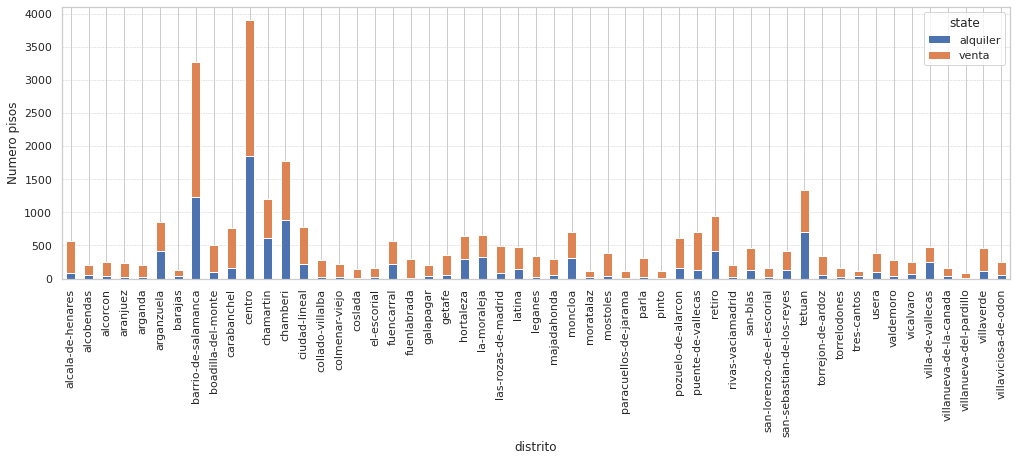

In [111]:
grouped = df.groupby(['distrito', 'state']).size().unstack(fill_value=0)

fig, ax = plt.subplots(figsize=(17, 5))
grouped.plot(kind='bar', stacked=True, ax=ax)
ax.grid(True, axis='y', linestyle='--', linewidth=0.5)
ax.set_ylabel('Numero pisos')
plt.show()

# Media precio de venta/alquiler por distrito

In [112]:
df['price'] = df['price'].str.replace('.', '').str.replace('€', '').str.replace('/mes', '').astype(float)

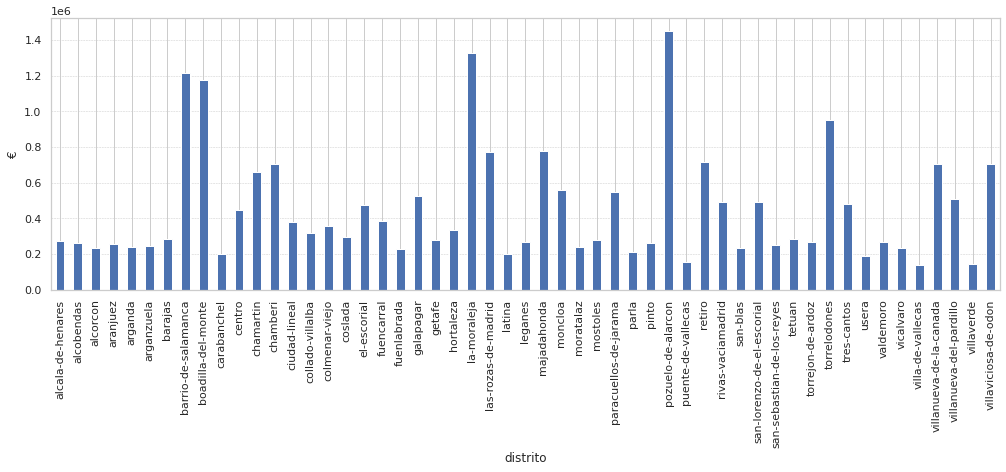

In [113]:
average_price = df.groupby('distrito')['price'].mean()

fig, ax = plt.subplots(figsize=(17, 5))
average_price.plot(kind='bar', stacked=True, ax=ax)
ax.grid(True, axis='y', linestyle='--', linewidth=0.5)
ax.set_ylabel('€')
plt.show()

# Media metros cuadrados

In [114]:
df['meters'] = df['meters'].str.replace('m²', '').str.replace('.', '').astype(float)

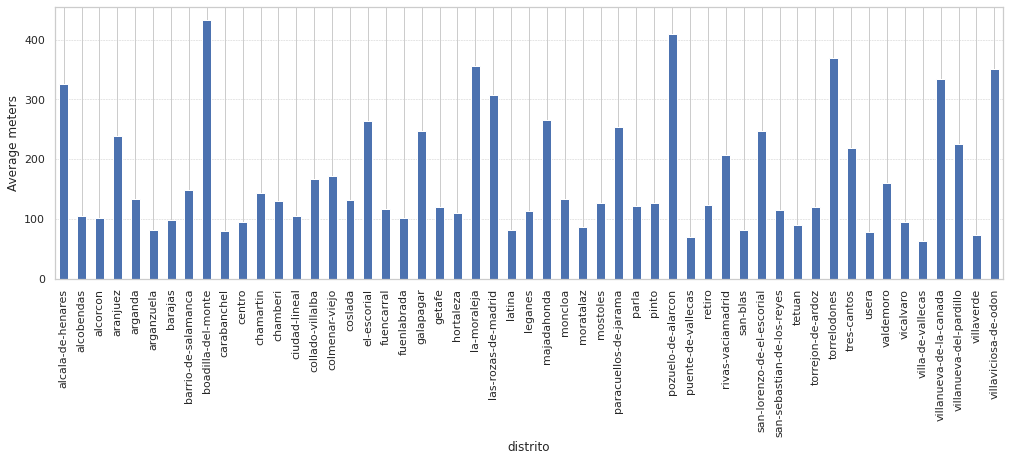

In [115]:
average_meters = df.groupby('distrito')['meters'].mean()
fig, ax = plt.subplots(figsize=(17, 5))
average_meters.plot(kind='bar', stacked=True, ax=ax)
ax.grid(True, axis='y', linestyle='--', linewidth=0.5)
ax.set_ylabel('Average meters')
plt.show()

0.7498067314664343 correlation between price and meters


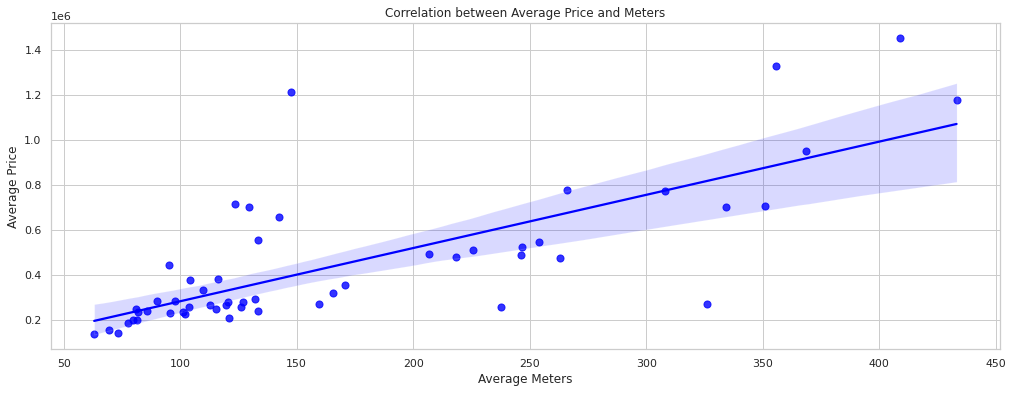

In [116]:
grouped = df.groupby('distrito').agg({'price': 'mean', 'meters': 'mean'})

correlation = grouped['price'].corr(grouped['meters'])

print(correlation, 'correlation between price and meters')

sns.set(style='whitegrid')
plt.figure(figsize=(17, 6))
sns.regplot(data=grouped, x='meters', y='price', scatter_kws={'s': 50}, color='blue')

plt.title('Correlation between Average Price and Meters')
plt.xlabel('Average Meters')
plt.ylabel('Average Price')
plt.show()

# Group each distrit in 
- 20-40
- 40-60
- 60-90
- 90-120
- 120

€/meter: 
1. coger casas en el rango de metros
2. coger el €/metro de cada casa. (metros entre precio venta/alquiler)
3. media de €/metro

distrito | rango_metros | # pisos venta | tiempo de venta? | €/meter venta | # pisos alquiler | tiempo en alquilar? | €/meter alquiler || PER | Rentabilidad Bruta

In [203]:
range_meters = {
    0: [0, 40],
    1: [40, 60], 
    2: [60, 90], 
    3: [90, 120], 
    4: [120, 1000]
}

def get_range_meters(meters):
    for r, _range in range_meters.items():
        if _range[0] <= meters < _range[1]:
            return r

df['range_meters'] = df['meters'].apply(get_range_meters)
df['€/meter'] = df['price'] / df['meters']

In [204]:
df_grouped = df.groupby(['distrito', 'range_meters', 'state']).agg({'€/meter': ['mean', 'size']}).reset_index()
df_grouped.columns = ['distrito', 'range_meters', 'state', '€/meter', 'size']

data = df_grouped.pivot_table(
    index=['distrito', 'range_meters'],
    columns='state',
    values=['€/meter', 'size']
).reset_index()
data.columns = ['distrito', 'range_meters', 'number alquiler', 'number venta', '€/meter alquiler', '€/meter venta']
data.fillna(0, inplace=True)

data['RB'] = data.apply(lambda x: ((x['€/meter alquiler'] * 12) / x['€/meter venta']) * 100 if x['€/meter venta'] > 0 else 0, axis=1)
data['PER'] = data.apply(lambda x: x['€/meter venta'] / (x['€/meter alquiler'] * 12) if x['€/meter alquiler'] > 0 else 0, axis=1)

data.head()

,distrito,range_meters,number alquiler,number venta,€/meter alquiler,€/meter venta,RB,PER
0,alcala-de-henares,0.0,0.0,2.0,0.000000,3164.285714,0.000000,0.000000
1,alcala-de-henares,1.0,7.0,26.0,15.995132,3397.737273,5.649100,17.701934
2,alcala-de-henares,2.0,47.0,161.0,14.091502,2465.717915,6.857963,14.581589
3,alcala-de-henares,3.0,21.0,106.0,11.598038,2630.324392,5.291228,18.899204
4,alcala-de-henares,4.0,12.0,182.0,9.710496,2309.539196,5.045420,19.819956


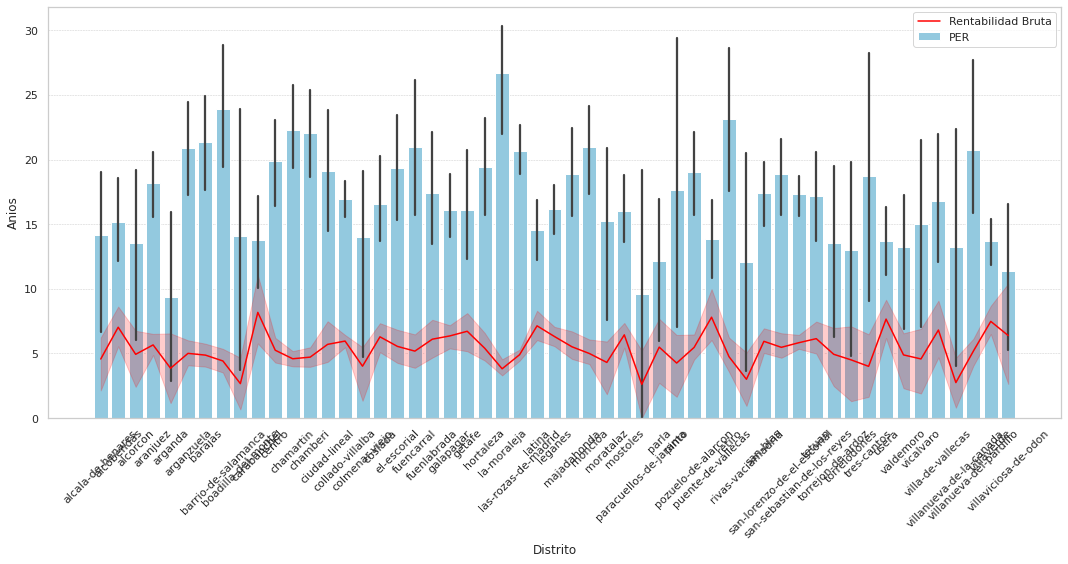

In [205]:
fig, ax = plt.subplots(figsize=(15, 8))

sns.barplot(data=data, x=data['distrito'], y='PER', ax=ax, color='skyblue', label='PER')
sns.lineplot(data=data, x=data['distrito'], y='RB', ax=ax, color='red', label='Rentabilidad Bruta')

ax.set_xlabel('Distrito')
ax.set_ylabel('Anios')

ax.grid(True, which='major', axis='y', linestyle='--', linewidth=0.5)
ax.tick_params(axis='x', rotation=45)
fig.tight_layout()
ax.legend()

plt.show()

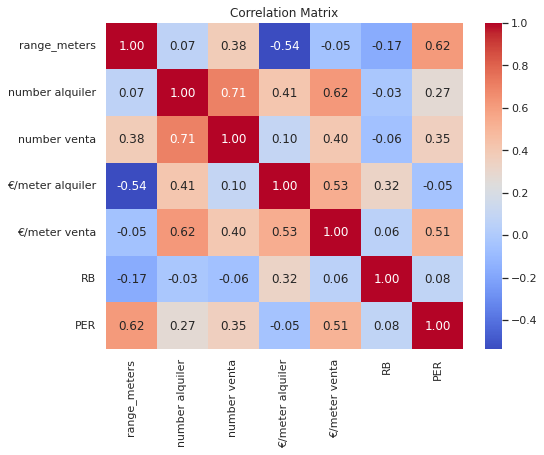

In [206]:
correlation_matrix = data[['range_meters', 'number alquiler', 'number venta', '€/meter alquiler', '€/meter venta', 'RB', 'PER']].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

In [213]:
range_meters_average = {
    0: 30,
    1: 50, 
    2: 80, 
    3: 100, 
    4: 120
}

data['range_meters_average'] = data['range_meters'].apply(lambda x: range_meters_average[x])
data['venta'] = data['range_meters_average'] * data['€/meter venta']
data['alquiler'] = data['range_meters_average'] * data['€/meter alquiler']

# revalorization: How much odes the flats cost when I finish paying for it. Just took into account the inflation
data['revalorization'] = data['venta'] * (2.4 * data['PER']) # IPC Nov 2024 Spain

# Normalize the columns using Min-Max scaling
scaler = MinMaxScaler()
data['normalized_revalorization'] = scaler.fit_transform(data[['revalorization']])
data['normalized_RB'] = scaler.fit_transform(data[['RB']])
data['inverse_PER'] = data['PER'].apply(lambda x: 1 / x if x > 0 else 0)
data['normalized_PER'] = scaler.fit_transform(data[['inverse_PER']])

data.head()

,distrito,range_meters,number alquiler,number venta,€/meter alquiler,€/meter venta,RB,PER,range_meters_average,venta,alquiler,revalorization,normalized_revalorization,normalized_RB,inverse_PER,normalized_PER
0,alcala-de-henares,0.0,0.0,2.0,0.000000,3164.285714,0.000000,0.000000,30,94928.571429,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000
1,alcala-de-henares,1.0,7.0,26.0,15.995132,3397.737273,5.649100,17.701934,50,169886.863648,799.756600,7.217583e+06,0.073596,0.419481,0.056491,0.419481
2,alcala-de-henares,2.0,47.0,161.0,14.091502,2465.717915,6.857963,14.581589,80,197257.433195,1127.320151,6.903184e+06,0.070390,0.509247,0.068580,0.509247
3,alcala-de-henares,3.0,21.0,106.0,11.598038,2630.324392,5.291228,18.899204,100,263032.439229,1159.803848,1.193065e+07,0.121654,0.392907,0.052912,0.392907
4,alcala-de-henares,4.0,12.0,182.0,9.710496,2309.539196,5.045420,19.819956,120,277144.703470,1165.259474,1.318319e+07,0.134426,0.374654,0.050454,0.374654


In [227]:
input_money = 100000 # I have this money

#weight_valorizacion = 0.4
weight_rent_anual = 0.3
weight_per = 0.7
#weight_prestamo = 0.4

In [228]:
data['prestamo'] = data['venta'].apply(lambda x: x - input_money) # keep just the ones with 0 or positive prestamo

filtered = data[data['prestamo'] > 0].copy()

filtered['normalized_prestamo'] = scaler.fit_transform(1 / filtered[['prestamo']])
filtered['score'] = (
                       weight_rent_anual * filtered['normalized_RB'] 
                     #+ weight_valorizacion * filtered['normalized_revalorization'] 
                     + weight_per * filtered['normalized_PER']
                     #+ weight_prestamo * filtered['normalized_prestamo']
                    )

cols = ['range_meters', '€/meter alquiler', '€/meter venta','normalized_prestamo',  'normalized_revalorization', 'normalized_RB', 'inverse_PER', 'normalized_PER']
filtered = filtered.drop(columns=cols)
filtered = filtered.sort_values(by=['prestamo'])
filtered.nlargest(50, 'score')

,distrito,number alquiler,number venta,RB,PER,range_meters_average,venta,alquiler,revalorization,prestamo,score
252,villaviciosa-de-odon,9.0,3.0,13.466880,7.425625,50,104000.000000,1167.129630,1.853436e+06,4000.000000,1.000000
45,carabanchel,23.0,21.0,13.345017,7.493434,30,102666.990163,1141.743938,1.846388e+06,2666.990163,0.990951
232,villa-de-vallecas,190.0,7.0,10.630967,9.406482,30,144582.142690,1280.873360,3.264022e+06,44582.142690,0.789416
5,alcobendas,10.0,3.0,10.039689,9.960468,30,123994.252874,1037.386437,2.964098e+06,23994.252874,0.745510
217,usera,24.0,4.0,9.958300,10.041875,30,143563.596491,1191.374459,3.459954e+06,43563.596491,0.739466
46,carabanchel,49.0,104.0,9.797847,10.206324,50,150249.976847,1226.771875,3.680400e+06,50249.976847,0.727551
247,villaverde,42.0,73.0,9.369353,10.673095,50,121636.791035,949.715065,3.115779e+06,21636.791035,0.695733
218,usera,29.0,65.0,9.330215,10.717866,50,166609.797532,1295.421075,4.285684e+06,66609.797532,0.692827
65,ciudad-lineal,14.0,7.0,8.942449,11.182619,30,144491.999229,1076.760304,3.877917e+06,44491.999229,0.664033
119,latina,27.0,6.0,8.833599,11.320414,30,130987.009757,964.238923,3.558785e+06,30987.009757,0.655950
